<a href="https://colab.research.google.com/github/Veldora00/Veldora00/blob/main/STOCKARBITRAGE_SHORT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


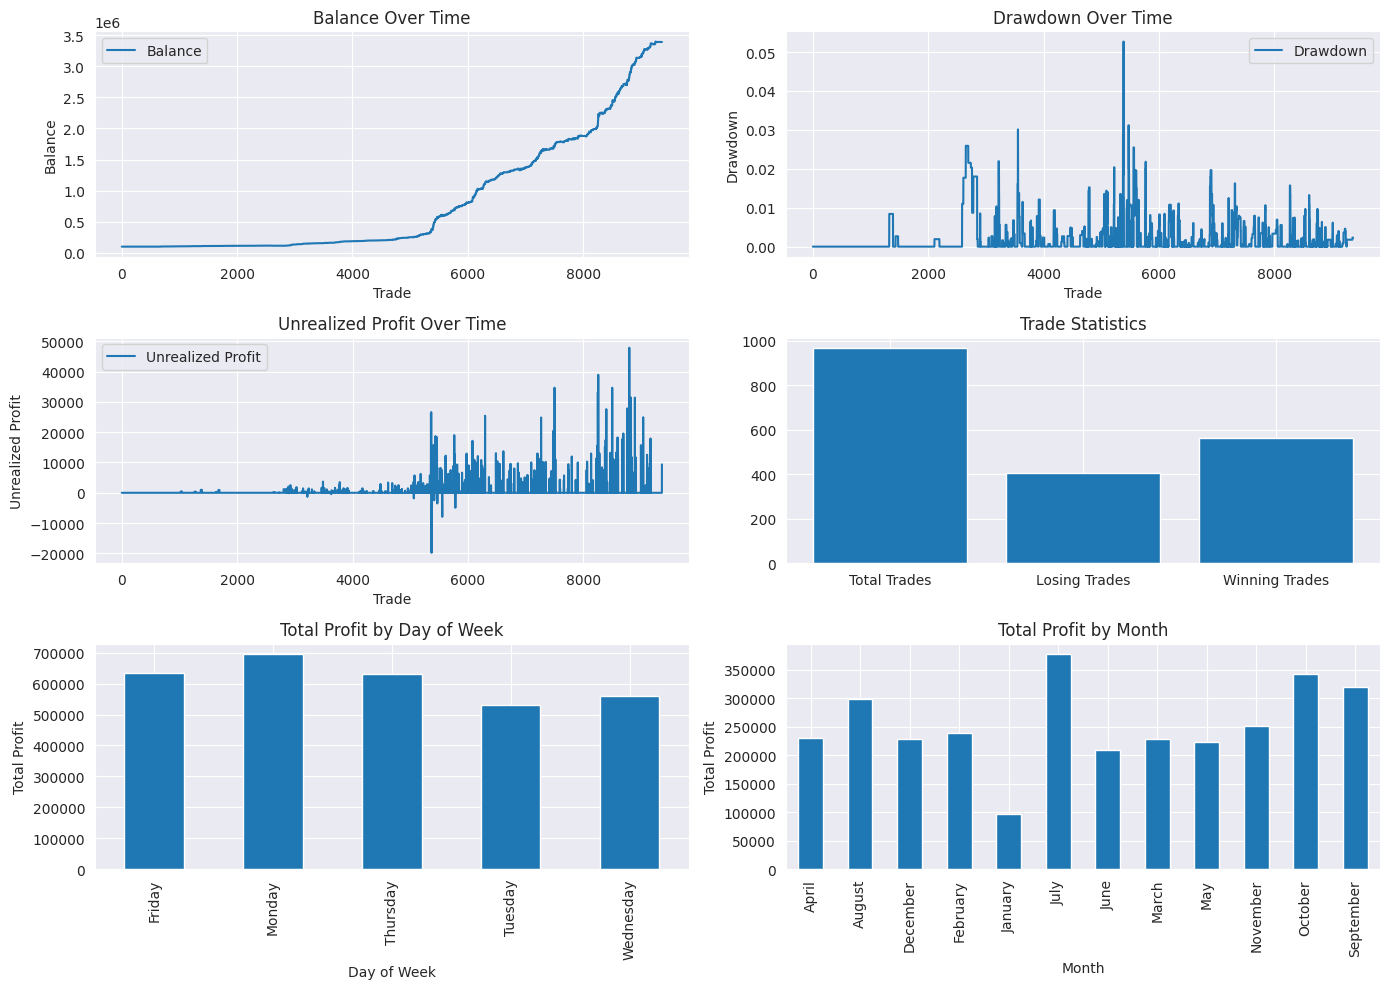

Net Profit: 3287715.491618252
Maximum Drawdown: 5.27%
Highest Balance Achieved: 3395586.8204915873
Total Trades: 966
Total Losing Trades: 404
Total Winning Trades: 561
Total SL Closures: 388
Total TP Closures: 577
Total Other Closures: 7404
Profits by Day of Week:
Day of Week
Friday       633148.596854
Monday       694262.637223
Thursday     631288.520720
Tuesday      529527.336117
Wednesday    559113.960597
Name: Profit, dtype: float64
Profits by Month:
Month
April        231076.338162
August       298439.424353
December     229161.284756
February     239554.636051
January       97488.939479
July         376941.848195
June         208938.969921
March        229308.554663
May          222739.418623
November     251591.108857
October      343022.894216
September    319077.634234
Name: Profit, dtype: float64
First Trade Entry: Date=1990-07-05 00:00:00, Entry Price=8.987512588500977
First Trade Exit: Date=1990-07-31 00:00:00, Exit Price=8.987512588500977, Profit/Loss=-0.0
Last Trade Entry

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf

# Set the style of the plots
sns.set_style('darkgrid')

# Fetch daily data from Yahoo Finance for the maximum period available
us_ticker = 'RIO'
asx_ticker = 'RIO.AX'

us_data = yf.download(us_ticker, period='max', interval='1d')
asx_data = yf.download(asx_ticker, period='max', interval='1d')

# Ensure the datetime index is properly formatted
us_data.index = us_data.index.tz_localize(None)
asx_data.index = asx_data.index.tz_localize(None)

# Calculate daily returns for US market
us_data['Daily Return'] = us_data['Close'].pct_change()

# Generate trading signals based on US market
us_data['Signal'] = np.where(us_data['Daily Return'] < -0.02, -1, 0)

# Merge US signals with ASX market data
merged_data = asx_data.join(us_data[['Signal']], how='left')

# Add day of the week and month columns
merged_data['Day of Week'] = merged_data.index.day_name()
merged_data['Month'] = merged_data.index.month_name()

# Implement trading strategy
initial_balance = 100000  # Initial balance in AUD
balance = initial_balance
position = 0  # Current position (-1: short, 0: no position)
entry_price = 0  # Entry price for the position

# Counters for tracking closures
sl_closures = 0
tp_closures = 0
other_closures = 0

# Metrics for analysis
balances = [initial_balance]
unrealized_profits = []
drawdowns = []
total_trades = 0
total_loss_trades = 0
total_profit_trades = 0
highest_balance = initial_balance
daily_profits = []  # Initialize with an empty list

# Track the first and last trades
first_trade_entry = None
first_trade_exit = None
last_trade_entry = None
last_trade_exit = None

for i in range(1, len(merged_data)):
    row = merged_data.iloc[i]
    profit = 0

    if row['Signal'] == -1 and position == 0:
        # Short signal and no current position
        trade_amount = balance * 0.5  # 50% of current balance
        entry_price = row['Open']
        us_session_low = us_data.loc[row.name, 'Low']
        us_session_high = us_data.loc[row.name, 'High']
        us_session_open = us_data.loc[row.name, 'Open']

        # Calculate percentage changes
        us_high_percent = (us_session_high - us_session_open) / us_session_open
        us_low_percent = (us_session_low - us_session_open) / us_session_open

        stop_price = entry_price * (1 + us_high_percent * 1.77)  # SL at 1.9 times the US session high percentage change
        tp_price = entry_price * ( 1 + us_low_percent * 1) # TP at the US low percentage change minus 0.04%
        position = -trade_amount / entry_price  # Number of shares shorted
        total_trades += 1

        # Record the first trade entry
        if first_trade_entry is None:
            first_trade_entry = (row.name, entry_price)

        # Record the last trade entry
        last_trade_entry = (row.name, entry_price)

    if position < 0:
        # Check for stop-loss
        if row['High'] > stop_price:
            loss = (stop_price - entry_price) * abs(position)
            balance -= loss
            total_loss_trades += 1
            sl_closures += 1
            daily_profits.append(-loss)
            position = 0

            # Record the first trade exit
            if first_trade_exit is None:
                first_trade_exit = (row.name, stop_price, -loss)

            # Record the last trade exit
            last_trade_exit = (row.name, stop_price, -loss)
        # Ensure position is closed at the tp price before market close
        elif row['Low'] <= tp_price:
            profit = (entry_price - tp_price) * abs(position)
            balance += profit
            if profit > 0:
                total_profit_trades += 1
            else:
                total_loss_trades += 1
            tp_closures += 1
            daily_profits.append(profit)
            position = 0

            # Record the first trade exit
            if first_trade_exit is None:
                first_trade_exit = (row.name, tp_price, profit)

            # Record the last trade exit
            last_trade_exit = (row.name, tp_price, profit)
        else:
            daily_profits.append(0)

    if position == 0 and profit == 0:
        daily_profits.append(0)
        other_closures += 1

    balances.append(balance)
    highest_balance = max(highest_balance, balance)
    drawdown = (highest_balance - balance) / highest_balance
    drawdowns.append(drawdown)
    unrealized_profit = (entry_price - row['Low']) * abs(position) if position < 0 else 0
    unrealized_profits.append(unrealized_profit)

# Calculate maximum drawdown
max_drawdown = max(drawdowns)
net_profit = balance - initial_balance

# Adjust the length of daily_profits if it doesn't match merged_data
if len(daily_profits) < len(merged_data):
    daily_profits += [0] * (len(merged_data) - len(daily_profits))
elif len(daily_profits) > len(merged_data):
    daily_profits = daily_profits[:len(merged_data)]

# Convert daily profits to DataFrame
profit_data = pd.DataFrame({
    'Date': merged_data.index,  # Include all dates
    'Profit': daily_profits  # Ensure lengths match
})
profit_data['Day of Week'] = profit_data['Date'].dt.day_name()
profit_data['Month'] = profit_data['Date'].dt.month_name()

# Group by day of week and month
profits_by_day = profit_data.groupby('Day of Week')['Profit'].sum()
profits_by_month = profit_data.groupby('Month')['Profit'].sum()

# Plotting the metrics
plt.figure(figsize=(14, 10))

plt.subplot(3, 2, 1)
plt.plot(balances, label='Balance')
plt.title('Balance Over Time')
plt.xlabel('Trade')
plt.ylabel('Balance')
plt.legend()

plt.subplot(3, 2, 2)
plt.plot(drawdowns, label='Drawdown')
plt.title('Drawdown Over Time')
plt.xlabel('Trade')
plt.ylabel('Drawdown')
plt.legend()

plt.subplot(3, 2, 3)
plt.plot(unrealized_profits, label='Unrealized Profit')
plt.title('Unrealized Profit Over Time')
plt.xlabel('Trade')
plt.ylabel('Unrealized Profit')
plt.legend()

plt.subplot(3, 2, 4)
plt.bar(['Total Trades', 'Losing Trades', 'Winning Trades'], [total_trades, total_loss_trades, total_profit_trades])
plt.title('Trade Statistics')

plt.subplot(3, 2, 5)
profits_by_day.plot(kind='bar')
plt.title('Total Profit by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Total Profit')

plt.subplot(3, 2, 6)
profits_by_month.plot(kind='bar')
plt.title('Total Profit by Month')
plt.xlabel('Month')
plt.ylabel('Total Profit')

plt.tight_layout()
plt.show()

# Output metrics
print(f"Net Profit: {net_profit}")
print(f"Maximum Drawdown: {max_drawdown * 100:.2f}%")
print(f"Highest Balance Achieved: {highest_balance}")
print(f"Total Trades: {total_trades}")
print(f"Total Losing Trades: {total_loss_trades}")
print(f"Total Winning Trades: {total_profit_trades}")
print(f"Total SL Closures: {sl_closures}")
print(f"Total TP Closures: {tp_closures}")
print(f"Total Other Closures: {other_closures}")
print("Profits by Day of Week:")
print(profits_by_day)
print("Profits by Month:")
print(profits_by_month)

# Print first and last trades
if first_trade_entry and first_trade_exit:
    print(f"First Trade Entry: Date={first_trade_entry[0]}, Entry Price={first_trade_entry[1]}")
    print(f"First Trade Exit: Date={first_trade_exit[0]}, Exit Price={first_trade_exit[1]}, Profit/Loss={first_trade_exit[2]}")

if last_trade_entry and last_trade_exit:
    print(f"Last Trade Entry: Date={last_trade_entry[0]}, Entry Price={last_trade_entry[1]}")
    print(f"Last Trade Exit: Date={last_trade_exit[0]}, Exit Price={last_trade_exit[1]}, Profit/Loss={last_trade_exit[2]}")